# Preprocessing

### Imports


In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GroupShuffleSplit
from sklearn.metrics import accuracy_score
from sklearn.inspection import permutation_importance
from sklearn.model_selection import cross_val_score, GroupKFold
from sklearn.linear_model import LogisticRegression
import seaborn as sns

In [2]:
#FILE PATH
file_path = '/home/cdennis51/code/Cdennis51/Neurocheck/raw_data/mental_fatigue/MEFAR_preprocessed/MEFAR_preprocessed/MEFAR_MID.csv'
df = pd.read_csv(file_path)

### Drop and assign columns 

In [3]:
print(df.columns.tolist())
df.columns = df.columns.str.strip()

['BVP', 'EDA', 'TEMP', 'AccX', 'AccY', 'AccZ', 'HR', ' Delta', ' Theta', ' Alpha1', ' Alpha2', ' Beta1', ' Beta2', ' Gamma1', ' Gamma2', ' Attention', ' Meditation', 'class']


In [4]:
#Load session map which defines start/end rows for each participant-session
session_map = pd.read_csv('/home/cdennis51/code/Cdennis51/Neurocheck/raw_data/mental_fatigue/Session_Map.csv')


In [5]:
#eeg_columns = ['Delta', 'Theta', 'Alpha1', 'Alpha2', 'Beta1', 'Beta2', 'Gamma1', 'Gamma2']
#X_eeg = df[eeg_columns].copy()
#y = df['class']

features = df.columns.drop('class')
X= df[features].copy()
y = df['class'].copy()

In [6]:
print(features)

Index(['BVP', 'EDA', 'TEMP', 'AccX', 'AccY', 'AccZ', 'HR', 'Delta', 'Theta',
       'Alpha1', 'Alpha2', 'Beta1', 'Beta2', 'Gamma1', 'Gamma2', 'Attention',
       'Meditation'],
      dtype='object')


## Creating the windows

In [7]:
sampling_rate = 32
window_seconds = 10 #Window size = 10 seconds of data--> 320 rows per window
window_size = sampling_rate * window_seconds
stride = int(window_size*0.5) #Stride = 50% overlap --> shifts 5 seconds at a time

In [16]:
#Slide window within each session to avoid mixing subjects/sessions

X_windows, y_windows, session_ids = [], [], []

for _, row in session_map.iterrows():     #returns each row of DF as tuple (i,r) _ means ignore index use row
    session_id = row['session_id']
    start = int(row['start_index'])
    end = int(row['end_index'])

    X_session = X.iloc[start:end].values
    y_session = y.iloc[start:end].values

    for i in range(0, len(X_session) - window_size + 1, stride):
        window = X_session[i:i + window_size]
        label = y_session[i + window_size - 1]  # Label taken from the end of the window
        # Majority voting below: label = 1 if more than 50% of labels in the window are 1
        #label = (y_session[i:i + window_size].mean() > 0.5).astype(int)
        X_windows.append(window)
        y_windows.append(label)
        session_ids.append(session_id)



# convert to np for modelling
X_windows = np.array(X_windows)
y_windows = np.array(y_windows)
session_ids = np.array(session_ids)

In [17]:
# not sure whether to normalise per window again maybe test and remove
X_norm = np.array([MinMaxScaler().fit_transform(window) for window in X_windows])

In [18]:
print(len(X))
print("Window size:", window_size)
print("Stride:", stride)

923298
Window size: 320
Stride: 160


In [19]:
# split into training and test sets using GroupShuffleSplit (grouped by session id)
splitter = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)  #prevents pverlap between train/test split for groups
train_idx, test_idx = next(splitter.split(X_norm, y_windows, groups=session_ids))

X_train, X_test = X_norm[train_idx], X_norm[test_idx]
y_train, y_test = y_windows[train_idx], y_windows[test_idx]

In [20]:

cv = GroupKFold(n_splits=5)
model = LogisticRegression(max_iter=1000)

#flattening doesn't work made too many features
# Flatten the 3D windowed data to 2D
#n_samples, time_steps, n_feats = X_norm.shape
#X_flat = X_norm.reshape(n_samples, time_steps * n_feats)


# instead sumarrise each window with 4 stats17x4 = 68 features (mean, std, min, max for each)
def summarize_window(window):
    return np.concatenate([
        window.mean(axis=0),
        window.std(axis=0),
        window.min(axis=0),
        window.max(axis=0)
    ])

X_summary = np.array([summarize_window(w) for w in X_norm])

cross_val_score(model, X_summary, y_windows, groups=session_ids, cv=cv)


array([0.76767677, 0.81481481, 0.7755102 , 0.68367347, 0.68367347])

for me each fold has 0.76767677, 0.81481481, 0.7755102 , 0.68367347, 0.68367347 - not bad???? - better than flattening which was aapprox 63%



### feature permutation

In [21]:
model = LogisticRegression(max_iter=1000)
model.fit(X_summary, y_windows)
y_pred = model.predict(X_summary)
print(accuracy_score(y_windows, y_pred))


result = permutation_importance(model, X_summary, y_windows, n_repeats=10, random_state=42)

# View top features

importance_df = pd.DataFrame({
    "feature_index": np.arange(X_summary.shape[1]),
    "importance_mean": result.importances_mean,
    "importance_std": result.importances_std
})
print(importance_df.sort_values(by="importance_mean", ascending=False).head(10))


0.7744510978043913
    feature_index  importance_mean  importance_std
4               4         0.017764        0.006018
3               3         0.007784        0.002886
0               0         0.006587        0.003225
5               5         0.005988        0.003571
9               9         0.005190        0.003702
15             15         0.004591        0.002533
16             16         0.004192        0.001397
14             14         0.002794        0.002223
10             10         0.001796        0.001075
12             12         0.001597        0.001494


In [22]:
#add readable names

raw_features = ['BVP', 'EDA', 'TEMP', 'AccX', 'AccY', 'AccZ', 'HR',
                'Delta', 'Theta', 'Alpha1', 'Alpha2', 'Beta1', 'Beta2',
                'Gamma1', 'Gamma2', 'Attention', 'Meditation']

#make name for all features i.e. BVP_mean/std/mix
summary_features = (
    [f"{name}_mean" for name in raw_features] +
    [f"{name}_std" for name in raw_features] +
    [f"{name}_min" for name in raw_features] +
    [f"{name}_max" for name in raw_features]
)

#map index to feature
importance_df['feature_name'] = importance_df['feature_index'].astype(int).map(lambda i: summary_features[i])

importance_df.sort_values(by="importance_mean", ascending=False).head(20)


,feature_index,importance_mean,importance_std,feature_name
4,4,0.017764,0.006018,AccY_mean
3,3,0.007784,0.002886,AccX_mean
0,0,0.006587,0.003225,BVP_mean
5,5,0.005988,0.003571,AccZ_mean
9,9,0.005190,0.003702,Alpha1_mean
15,15,0.004591,0.002533,Attention_mean
16,16,0.004192,0.001397,Meditation_mean
14,14,0.002794,0.002223,Gamma2_mean
10,10,0.001796,0.001075,Alpha2_mean
12,12,0.001597,0.001494,Beta2_mean


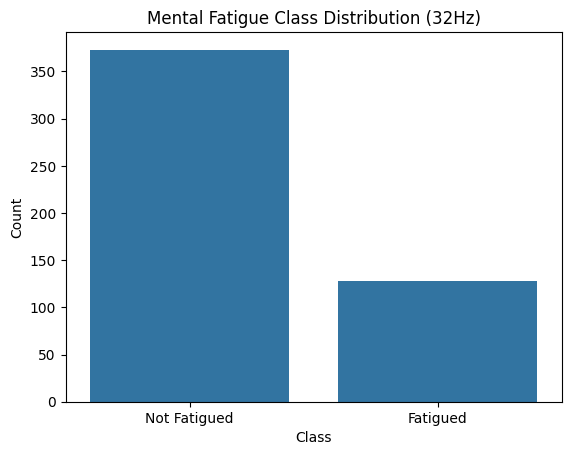

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(x=y_windows)
plt.title("Mental Fatigue Class Distribution (32Hz)")
plt.xticks([0, 1], ['Not Fatigued', 'Fatigued'])
plt.xlabel("Class")
plt.ylabel("Count")
plt.show()


In [25]:
import numpy as np
import pandas as pd

def report_split_info(session_ids, y_windows, train_idx, test_idx):
    """
    Prints a summary of the train/test split, including:
    - Sessions used in train vs test
    - Number of windows per session
    - Label distribution per split
    """
    train_sessions = np.unique(session_ids[train_idx])
    test_sessions = np.unique(session_ids[test_idx])

    print("=== TRAIN/TEST SPLIT REPORT ===")
    print(f"Total windows: {len(y_windows)}")
    print(f"Train windows: {len(train_idx)}, Test windows: {len(test_idx)}")
    print("\nTrain Sessions:", train_sessions)
    print("Test Sessions:", test_sessions)

    # Count windows per session
    train_counts = pd.Series(session_ids[train_idx]).value_counts().sort_index()
    test_counts = pd.Series(session_ids[test_idx]).value_counts().sort_index()
    print("\nWindows per Train Session:\n", train_counts)
    print("\nWindows per Test Session:\n", test_counts)

    # Label distributions
    train_labels = pd.Series(y_windows[train_idx]).value_counts()
    test_labels = pd.Series(y_windows[test_idx]).value_counts()
    print("\nTrain label distribution:\n", train_labels)
    print("\nTest label distribution:\n", test_labels)


In [ ]:
report_split_info(session_ids, y_windows, train_idx, test_idx)


=== TRAIN/TEST SPLIT REPORT ===
Total windows: 501
Train windows: 391, Test windows: 110

Train Sessions: ['sub01_evening' 'sub01_morning' 'sub02_evening' 'sub03_morning'
 'sub04_evening' 'sub04_morning' 'sub05_morning' 'sub06_evening'
 'sub06_morning' 'sub07_morning' 'sub08_evening' 'sub08_morning'
 'sub09_evening' 'sub09_morning' 'sub10_evening' 'sub10_morning'
 'sub11_evening' 'sub11_morning' 'sub12_evening' 'sub12_morning'
 'sub13_evening' 'sub14_morning' 'sub15_evening' 'sub15_morning'
 'sub16_evening' 'sub16_morning' 'sub17_evening' 'sub17_morning'
 'sub18_evening' 'sub19_evening' 'sub19_morning' 'sub20_evening'
 'sub21_evening' 'sub22_evening' 'sub22_morning' 'sub23_morning']
Test Sessions: ['sub02_morning' 'sub03_evening' 'sub05_evening' 'sub07_evening'
 'sub13_morning' 'sub14_evening' 'sub18_morning' 'sub20_morning'
 'sub21_morning' 'sub23_evening']

Windows per Train Session:
 sub01_evening    10
sub01_morning    10
sub02_evening    11
sub03_morning    11
sub04_evening    11
